# Heart Failure Prediction

1. **Data Loading**: Importing the heart failure clinical dataset.
2. **Exploratory Data Analysis (EDA)**: Visualizing distributions, correlations, and class balance.
3. **Preprocessing**: Scaling features and encoding as necessary.
4. **Model Training**: Hyperparameter tuning with `GridSearchCV` and `StratifiedKFold`.
5. **Evaluation**: Classification metrics, ROC AUC, confusion matrix, and feature importance plotting.
6. **Saving Artifacts**: Persisting the trained model and scaler for future inference.


In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import joblib

# Set visualization styles
sns.set(style="whitegrid")

# Ensure plots appear in the notebook
%matplotlib inline

## 1. Load Dataset

We load the `heart.csv` file and verify its shape, column names, and a preview of the first rows.


In [2]:
def load_data(path: str) -> pd.DataFrame:
    """
    Load the heart failure dataset from a CSV file.
    Raises:
        FileNotFoundError: If the file is not found at the given path.
    Returns:
        pd.DataFrame: Loaded dataset.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found. Please place the dataset in the notebook directory.")
    df = pd.read_csv(path)
    return df

In [4]:
# Load and inspect
data_path = 'heart.csv'
df = load_data(data_path)
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### 2.1 Summary Statistics


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


### 2.2 Feature Correlations

Plot a heatmap to identify strong correlations among features, which may inform feature selection or multicollinearity handling.


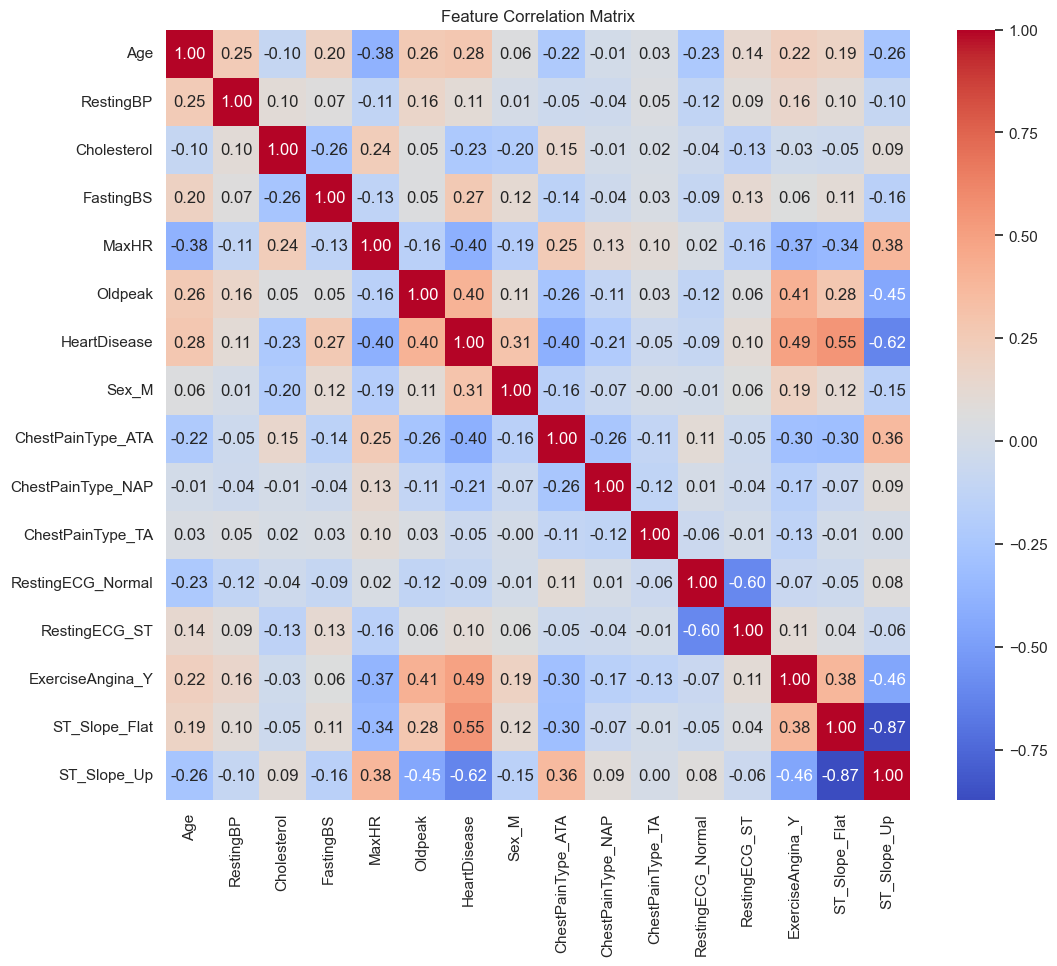

In [11]:
df_numeric = pd.get_dummies(df, drop_first=True)
plt.figure(figsize=(12,10))
correlation = df_numeric.corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

## 3. Preprocessing

We separate the features from the target and standardize the feature set using `StandardScaler`. This ensures all features contribute equally to the model.

In [12]:
def preprocess(df: pd.DataFrame):
    """
    Separates features and target, applies standard scaling to features.
    Returns scaled features, target, fitted scaler, and feature names.
    """
    X = df.drop('HeartDisease', axis=1)
    y = df['HeartDisease']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y, scaler, X.columns

In [14]:
X, y, scaler, feature_names = preprocess(df_numeric)
print(f"Features scaled: {X.shape[1]}")

Features scaled: 15


## 4. Train-Test Split

Split the data into training and testing sets, preserving class balance with stratification.


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 734, Testing samples: 184


## 5. Model Training

Use `XGBClassifier` with hyperparameter tuning via `GridSearchCV` and 5-fold stratified cross-validation, optimizing for ROC AUC.


In [16]:
def train_model(X_train, y_train):
    """
    Trains an XGBoost classifier with hyperparameter grid search.
    Returns the best estimator found.
    """
    xgb = XGBClassifier(
        use_label_encoder=False, eval_metric='logloss', random_state=42
    )
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(
        xgb, param_grid, scoring='roc_auc', cv=cv,
        n_jobs=-1, verbose=2
    )
    grid.fit(X_train, y_train)
    print('Best Parameters:', grid.best_params_)
    print(f"Best ROC AUC: {grid.best_score_:.4f}")
    return grid.best_estimator_

In [17]:
# Train and obtain best model
best_model = train_model(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estima

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estima

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimato

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estima

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:36:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 6. Model Evaluation

Evaluate the trained model on the test set using various performance metrics.


In [19]:
def evaluate_model(model, X_test, y_test):
    """
    Prints classification report, accuracy, ROC AUC, and plots confusion matrix.
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87        82
           1       0.90      0.89      0.90       102

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89      0.89      0.89       184

Accuracy: 0.8859
ROC AUC: 0.9393


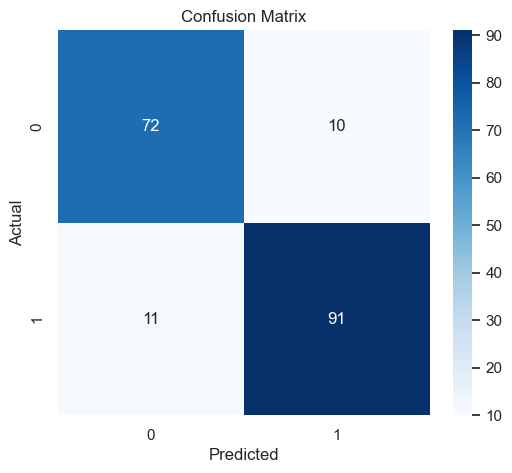

In [20]:
evaluate_model(best_model, X_test, y_test)


## 7. Feature Importance

Plot the top 10 most important features as identified by the XGBoost model.

In [21]:
def plot_feature_importance(model, feature_names, top_n: int = 10):
    """
    Plots the top_n feature importances from the model.
    """
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names)
    feat_imp = feat_imp.sort_values(ascending=False).head(top_n)
    plt.figure(figsize=(8,6))
    sns.barplot(x=feat_imp, y=feat_imp.index)
    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()

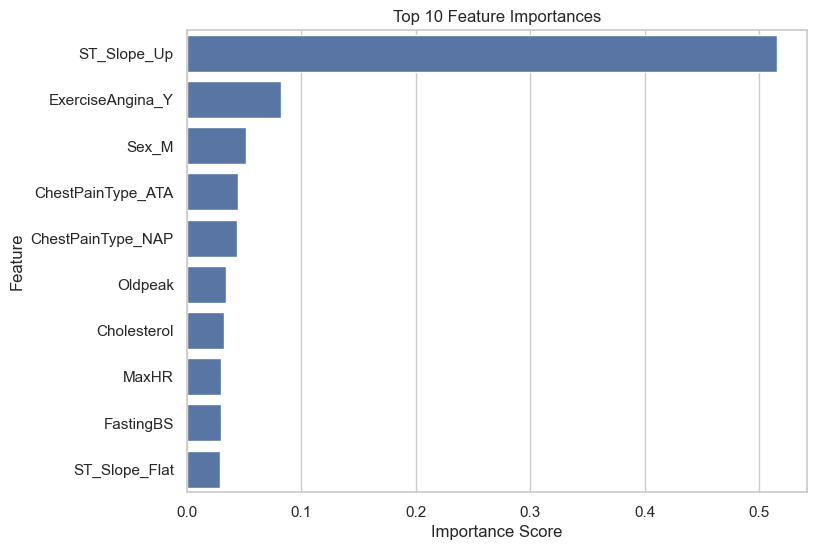

In [22]:
plot_feature_importance(best_model, feature_names, top_n=10)

## 8. Save Model and Scaler

Persist the trained model and scaler using `joblib` for later use in inference or deployment.


In [23]:
model_path = 'heart_failure_xgb_model.pkl'
scaler_path = 'scaler.pkl'
joblib.dump(best_model, model_path)
joblib.dump(scaler, scaler_path)
print(f"Model saved to {model_path}")
print(f"Scaler saved to {scaler_path}")

Model saved to heart_failure_xgb_model.pkl
Scaler saved to scaler.pkl
